In [1]:
import os 
import pandas as pd
from bs4 import BeautifulSoup
import re
from datetime import date
from tqdm import tqdm



    

pd.set_option('mode.chained_assignment', None)

In [2]:
#Getting the names of or downloaded boxscore in a list
SCORE_DIR = 'data/scores'
box_scores = os.listdir(SCORE_DIR)

In [3]:
print(f'we have {len(box_scores)} games scraped')

we have 2494 games scraped


In [4]:
# joining the names of the boxscores with ther directory
box_scores = [os.path.join(SCORE_DIR, file) for file in box_scores if file.endswith('.html')] # file names

we want to grab
 1 -  who win

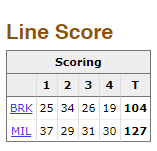
 
 Here, the home team is always in the second line.


In [5]:
def get_score_line(soup):
    score_row = pd.read_html(str(soup), attrs={'id': 'line_score'})[0] # grab the first table, thats actually the table we want
    # we get to change name of first column and last column (total and teams names) because colunns dinamically change in between
    score_row.columns.values[0] = 'Team' # first column with the teams name
    score_row.columns.values[-1] = 'Total' # switch name of T for Total
    score_row = score_row[['Team', 'Total']] # we get only the important values for us, and ignore the partial scores.

    return score_row




2- basic and advanced scores

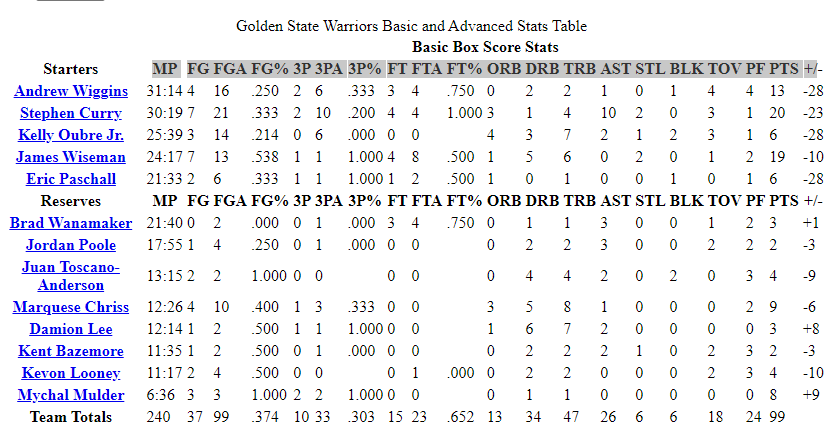

We want to remove the
'Basic Box Score Stats' table title
and the columns names that appear in the reserves section of the table



In [6]:
def clean_html(box_score):
    
    with open(box_score, 'r', encoding="utf-8", errors='ignore') as f:
        html = f.read()
    
    soup = BeautifulSoup(html)
    [f.decompose() for f in soup.select('tr.over_header')]
    [f.decompose() for f in soup.select('tr.thead')]
   

    return soup


Now, we gonna create a function to grab the basic and advanced stats by team, in a list of the 2 teams that are playing each other

In [7]:
def get_stats(soup, team, stat):
    
    df = pd.read_html(str(soup), attrs={'id':f'box-{team}-game-{stat}'}, index_col=0)[0] # indexcol will be the players column
    
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

Function to get the season of that game.

In [8]:
def get_game_season(soup):
    id = soup.select('#bottom_nav_container')[0]
    string= id.find_all('u')[3] # this u tag has the exact season, so we use regex to extract it
    return re.findall(r'\d{4}-\d{2}', str(string))[0]

# With the get stats function, we have the tables of the basic and advanced stats.

I will now concatenate these 2 tables, and only with the content of the last line of the table, the team totals. taht gonna be the feature row per team.

Now we can approach our data in 2 different ways, to get the team stats of that match taking in account if the team is home ou away, the win ou loss target, and the opponent team stats, in a single row for that team name:

1 - The team 1 stats + CONCATENATING + the team 2 stats to get the 1 team feature in one row, and inverting to get the same for team 2

2 - The team 1 stats / the team 2 stats to get the 1 team feature in one row, and inverting to get the same for team 2




In [9]:

base_cols = None
games = []
games_ids = []
count = 0 # coounting the number of corrupted html files

for box_score in tqdm(box_scores): # tqm to track progress.

    game_file_name = os.path.basename(box_score)

    if game_file_name in games_ids: # if this data was aready grabbed, go to next
        continue

    
    try:  # if html is somewaht corrupted, we go to the next
        soup = clean_html(box_score)
        score_row = get_score_line(soup)
        
        all_stats = [] # this is resposible to store data from both teams

        for team in score_row['Team']:
            
            # we do not need the +/- and BPM columns, as they are not present in totals of the team standings
            basic_df = get_stats(soup, team, 'basic')      
            advanced_df = get_stats(soup, team, 'advanced')
            

            # we only need the totals row of the stats table, and we need to concatenated both basic and advanced table
            totals = pd.concat([basic_df.iloc[-1], advanced_df.iloc[-1]], axis=0)# concat 2 series
            totals.index = totals.index.str.lower()
            
            
            

            # getting also the coluns of te max individual stat per player, so we exclude totals. This line , maxes, is optional.
            maxes = pd.concat([basic_df.iloc[:-1].max(), advanced_df.iloc[:-1].max()], axis=0)
            maxes.index =  maxes.index.str.lower() + '_max' 

            stats = pd.concat([totals, maxes], axis=0)
            

            #some tables do not have the same rows, with a variable named bpm, and duplicates, so we gonna deal with

            if base_cols is None:
                base_cols = list(stats.index.drop_duplicates(keep='first'))
                base_cols = [col for col in base_cols if 'bpm' not in col]

            stats = stats[base_cols]

            # append for both teams

            all_stats.append(stats)

        stats = pd.concat(all_stats, axis=1).T # stacking rows of teams

        # combining the score row with stats to get the points and the name of the team
        game_stats = pd.concat([stats, score_row], axis=1) # stacking columns of dfs
        game_stats['season'] = get_game_season(soup)

        # getting just the date of the file name
        
        game_stats['date'] = pd.to_datetime(game_file_name[:8])
        
        

        game_stats['home'] = [0, 1]  # as the home team is always second in the list, we just index this way
        
        game_stats_opponent = game_stats.iloc[::-1].reset_index() # let us concatenate later
        game_stats_opponent.columns = 'opponent_' + game_stats_opponent.columns 

        

        full_game_stats = pd.concat([game_stats, game_stats_opponent], axis=1)
        full_game_stats['ID'] = game_file_name
        full_game_stats['WIN'] = full_game_stats['Total'] > full_game_stats['opponent_Total'] #adding the target column WIN (1) or LOSS (0)

        games.append(full_game_stats)
        games_ids.append(game_file_name) # appending the game unique file name

        
    except:
        count += 1
        print(f'Number of corrupted boxes: {count}')
        print(f'Corrupted box: {game_file_name}')
        continue








   


    
    

  2%|▏         | 50/2494 [01:08<53:29,  1.31s/it]  

Progress: 200.5%...


  4%|▍         | 100/2494 [02:14<50:41,  1.27s/it]

Progress: 401.0%...


  6%|▌         | 150/2494 [03:16<48:25,  1.24s/it]

Progress: 601.4%...


  8%|▊         | 200/2494 [04:18<50:55,  1.33s/it]

Progress: 801.9%...


 10%|█         | 250/2494 [05:21<47:09,  1.26s/it]

Progress: 1002.4%...


 12%|█▏        | 300/2494 [06:24<44:45,  1.22s/it]

Progress: 1202.9%...


 14%|█▍        | 350/2494 [07:26<42:49,  1.20s/it]

Progress: 1403.4%...


 16%|█▌        | 400/2494 [08:26<42:18,  1.21s/it]

Progress: 1603.8%...


 18%|█▊        | 450/2494 [09:27<41:46,  1.23s/it]

Progress: 1804.3%...


 20%|██        | 500/2494 [10:29<42:30,  1.28s/it]

Progress: 2004.8%...


 22%|██▏       | 550/2494 [11:32<43:03,  1.33s/it]

Progress: 2205.3%...


 24%|██▍       | 600/2494 [12:36<38:34,  1.22s/it]

Progress: 2405.8%...


 26%|██▌       | 650/2494 [13:43<43:18,  1.41s/it]

Progress: 2606.3%...


 28%|██▊       | 700/2494 [14:46<36:59,  1.24s/it]

Progress: 2806.7%...


 28%|██▊       | 707/2494 [14:55<38:29,  1.29s/it]

Number of corrupted boxes: 708
Corrupted box: 202104010DET.html


 30%|███       | 751/2494 [15:50<38:11,  1.31s/it]

Progress: 3007.2%...


 32%|███▏      | 801/2494 [16:54<36:53,  1.31s/it]

Progress: 3207.7%...


 34%|███▍      | 851/2494 [18:00<35:33,  1.30s/it]

Progress: 3408.2%...


 36%|███▌      | 901/2494 [19:08<35:59,  1.36s/it]

Progress: 3608.7%...


 38%|███▊      | 951/2494 [20:14<31:54,  1.24s/it]

Progress: 3809.1%...


 40%|████      | 1001/2494 [21:18<32:14,  1.30s/it]

Progress: 4009.6%...


 42%|████▏     | 1051/2494 [22:21<30:10,  1.25s/it]

Progress: 4210.1%...


 44%|████▍     | 1101/2494 [23:29<33:57,  1.46s/it]

Progress: 4410.6%...


 46%|████▌     | 1151/2494 [24:42<31:25,  1.40s/it]

Progress: 4611.1%...


 48%|████▊     | 1201/2494 [25:59<28:44,  1.33s/it]

Progress: 4811.5%...


 50%|█████     | 1251/2494 [27:04<26:36,  1.28s/it]

Progress: 5012.0%...


 52%|█████▏    | 1301/2494 [28:08<25:23,  1.28s/it]

Progress: 5212.5%...


 54%|█████▍    | 1351/2494 [29:12<24:32,  1.29s/it]

Progress: 5413.0%...


 56%|█████▌    | 1401/2494 [30:15<23:26,  1.29s/it]

Progress: 5613.5%...


 58%|█████▊    | 1451/2494 [31:19<22:35,  1.30s/it]

Progress: 5814.0%...


 60%|██████    | 1501/2494 [32:23<19:58,  1.21s/it]

Progress: 6014.4%...


 62%|██████▏   | 1551/2494 [33:26<19:45,  1.26s/it]

Progress: 6214.9%...


 64%|██████▍   | 1601/2494 [34:28<18:12,  1.22s/it]

Progress: 6415.4%...


 66%|██████▌   | 1651/2494 [35:30<17:05,  1.22s/it]

Progress: 6615.9%...


 68%|██████▊   | 1701/2494 [36:33<17:03,  1.29s/it]

Progress: 6816.4%...


 70%|███████   | 1751/2494 [37:36<16:13,  1.31s/it]

Progress: 7016.8%...


 72%|███████▏  | 1801/2494 [38:40<14:41,  1.27s/it]

Progress: 7217.3%...


 74%|███████▍  | 1851/2494 [39:42<13:27,  1.26s/it]

Progress: 7417.8%...


 76%|███████▌  | 1901/2494 [40:45<12:16,  1.24s/it]

Progress: 7618.3%...


 78%|███████▊  | 1951/2494 [41:48<11:04,  1.22s/it]

Progress: 7818.8%...


 80%|████████  | 2001/2494 [42:50<09:54,  1.21s/it]

Progress: 8019.2%...


 82%|████████▏ | 2051/2494 [43:52<09:37,  1.30s/it]

Progress: 8219.7%...


 84%|████████▍ | 2101/2494 [44:55<08:21,  1.28s/it]

Progress: 8420.2%...


 86%|████████▌ | 2151/2494 [45:57<07:04,  1.24s/it]

Progress: 8620.7%...


 88%|████████▊ | 2201/2494 [47:00<06:06,  1.25s/it]

Progress: 8821.2%...


 90%|█████████ | 2251/2494 [48:03<04:57,  1.22s/it]

Progress: 9021.7%...


 92%|█████████▏| 2301/2494 [49:05<04:03,  1.26s/it]

Progress: 9222.1%...


 94%|█████████▎| 2336/2494 [49:48<03:00,  1.14s/it]

Number of corrupted boxes: 2336
Corrupted box: 202204020PHI.html


 94%|█████████▍| 2352/2494 [50:08<02:55,  1.24s/it]

Progress: 9422.6%...


 96%|█████████▋| 2402/2494 [51:12<01:51,  1.22s/it]

Progress: 9623.1%...


 98%|█████████▊| 2452/2494 [52:14<00:52,  1.24s/it]

Progress: 9823.6%...


100%|██████████| 2494/2494 [53:08<00:00,  1.28s/it]


In [12]:
#checking the shape of all dataframes
len(games)

2492

In [14]:
games[4]

,mp,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,...,opponent_tov%_max,opponent_usg%_max,opponent_ortg_max,opponent_drtg_max,opponent_Team,opponent_Total,opponent_season,opponent_date,opponent_home,WIN
0,240.0,240.0,45.0,90.0,0.500,16.0,44.0,0.364,8.0,15.0,...,33.3,100.0,150.0,122.0,CLE,121,2020-21,2020-12-23,1,False
1,240.0,240.0,46.0,87.0,0.529,14.0,30.0,0.467,15.0,20.0,...,37.5,31.8,178.0,128.0,CHO,114,2020-21,2020-12-23,0,True


In [ ]:
#checking the shape of all dataframes
print(games.shape)
[game.shape for game in games if game.shape != (2, 150)]

In [ ]:
# saving our file in a single dataframe and then to a csv
df_games = pd.concat(games, axis=1, ignore_index=True) # stack rows of games, assuming all dfs have the same columns

In [ ]:
# ... and then to a csv
df_games.to_csv('nba_games.csv')

In [ ]:
basic_df.iloc[-1]

MP     240.000
FG      38.000
FGA     81.000
FG%      0.469
3P       9.000
3PA     29.000
3P%      0.310
FT      24.000
FTA     31.000
FT%      0.774
ORB      8.000
DRB     37.000
TRB     45.000
AST     22.000
STL      4.000
BLK      2.000
TOV     19.000
PF      20.000
PTS    109.000
+/-        NaN
Name: Team Totals, dtype: float64

In [ ]:
game_stats['home'] = [1,2,3,4]

In [ ]:
game_stats['home']

0    1
1    2
2    3
3    4
Name: home, dtype: int64

In [ ]:
len(full_game_stats) 

2

## The first approach:

In [ ]:
full_game_stats

,mp,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,...,opponent_tov%_max,opponent_usg%_max,opponent_ortg_max,opponent_drtg_max,opponent_Team,opponent_Total,opponent_season,opponent_date,opponent_home,WIN
0,240.0,240.0,37.0,99.0,0.374,10.0,33.0,0.303,15.0,23.0,...,50.0,32.1,267.0,120.0,BRK,125,2020-21,2020-12-22,1,False
1,240.0,240.0,37.0,99.0,0.374,10.0,33.0,0.303,15.0,23.0,...,50.0,32.1,267.0,120.0,GSW,99,2020-21,2020-12-22,0,True


# TESTING

In [ ]:
#testing
box_score = box_scores[0] # grab a unique example for testing
soup = clean_html(box_score)
score_row = get_score_line(soup)

teams = score_row['Team']


basic_df = get_stats(soup, teams[0], 'basic').drop(labels='+/-', axis=1)
advanced_df = get_stats(soup, teams[0], 'advanced').drop(labels='BPM', axis=1)




GSW basic
GSW advanced


In [ ]:
score_row


,Team,Total
0,GSW,99
1,BRK,125


In [ ]:
score_row

,Team,Total
0,GSW,99
1,BRK,125


In [ ]:
basic_df.head(3)



,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Starters,,,,,,,,,,,,,,,,,,,
Andrew Wiggins,NaN,4,16,0.250,2,6,0.333,3,4,0.75,0,2,2,1,0,1,4,4,13
Stephen Curry,NaN,7,21,0.333,2,10,0.200,4,4,1.00,3,1,4,10,2,0,3,1,20
Kelly Oubre Jr.,NaN,3,14,0.214,0,6,0.000,0,0,NaN,4,3,7,2,1,2,3,1,6


In [ ]:
advanced_df.head(3)

,MP,TS%,eFG%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg
Starters,,,,,,,,,,,,,,,
Andrew Wiggins,NaN,0.366,0.313,0.375,0.25,0.0,6.5,3.0,5.0,0.0,2.7,18.4,26.3,63.0,118.0
Stephen Curry,NaN,0.439,0.381,0.476,0.19,8.3,3.4,6.1,61.1,2.9,0.0,11.6,32.1,99.0,114.0
Kelly Oubre Jr.,NaN,0.214,0.214,0.429,0.00,13.1,11.9,12.6,11.9,1.7,6.6,17.6,25.0,54.0,110.0
